In [1]:
from sys import path
if '..' not in path:
    path.insert(0, '..')

In [2]:
from os import path, makedirs, environ
import numpy as np
import random
import json

In [3]:
seed = 101
environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed) 
random.seed(seed)

In [4]:
#environ["CUDA_VISIBLE_DEVICES"] = ""

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import _library.lstm_utils as lstm_utils

In [6]:
from _library.utils import SYSTEM_NAMES, SUBFOLDERS, load_datasets
from tensorflow.random import set_seed as tf_set_seed
from string import ascii_uppercase 
from collections import Counter
from re import match, findall
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model  
from tensorflow.keras import metrics as metrics
from sklearn.ensemble import ExtraTreesClassifier

In [7]:
tf_set_seed(seed)

In [8]:
%cd /mnt/data/vieri/projects/SAMPLE/

/mnt/data/vieri/projects/SAMPLE


# 1) The photovoltaic systems

In [9]:
print(SYSTEM_NAMES, "\nSUBFOLDERS: -->", SUBFOLDERS)
# --- 0 ---------- 1 ---------- 2 --------- 3 ---------- 4 -------

['Binetto 1', 'Binetto 2', 'Soleto 1', 'Soleto 2', 'Galatina'] 
SUBFOLDERS: --> ['Cleaned', '1-hour sampling', '1-hour averaged sampling', 'Residuals', 'Residuals_analytical', 'Failure events', None]


## 1.1) Selecting the PV system

In [10]:
system_name = SYSTEM_NAMES[4]

In [11]:
system_path = path.join('data', system_name.upper(), system_name.upper())
print(f"PV SYSTEM --> {system_name}")

PV SYSTEM --> Galatina


## 1.2) Load the failure logs

In [12]:
data_folder = 'Failure events'

In [13]:
file_name = 'HighMedium_failureEvent_logs.csv'

In [14]:
folder_path = path.join(system_path, 'Imported data' , data_folder)
fault_df, unique_events = lstm_utils.load_failure_logs(folder_path, file_name, system_name, verbose = True)

--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- GALATINA --------------------------------------------------
--------------------------------------------------------------------------------------------------------------
Logs concerning failure events have been loaded.

---------------------------------------- DATA AVAILABLE ----------------------------------------
--> Inverter available (4):  1, 2, 3, 4
--> Unique events (5)
	--> 1) (HIGH) Allarme fusibile su polo negativo
	--> 2) (HIGH) Allarme fusibile su polo positivo
	--> 3) (HIGH) Isolamento
	--> 4) (HIGH) String-box con corrente a 0
	--> 5) (MEDIUM) Corrente di stringa fuori range

--> Unique string names available (12): s1, s2, s3, s4, s5, s6, s7, s8, s9, s10, s11, s12

--> General Plant box available (24):
	--> QC1.I1
	--> QC1.I2
	--> QC1.I3
	--> QC1.I4
	--> QC2.I1
	--> QC2.I2
	--> QC2.I3
	--> QC2.I4
	--> QC3.I1
	-->

# 2) Explore the data

## 2.1) The dataframe

In [15]:
print("-" * 110 + "\n" + "-" * 50, system_name.upper(), "-" * 50 + "\n" + "-" * 110)

print("\n", "-" * 40, 'FEATURES', "-" * 40)
fault_df.info()
print("\n" + "-" * 20, f'LOG EXAMPLES (COVERED PERIOD: FROM {fault_df["Inizio"].iloc[0].strftime("%Y-%m-%d")} '\
        f'TO {fault_df["Inizio"].iloc[-1].strftime("%Y-%m-%d")})', "-" * 20)
display(fault_df)

--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- GALATINA --------------------------------------------------
--------------------------------------------------------------------------------------------------------------

 ---------------------------------------- FEATURES ----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137365 entries, 0 to 137364
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype          
---  ------           --------------   -----          
 0   Inverter         137365 non-null  Int64          
 1   Quadro Generale  137365 non-null  object         
 2   Stringa          135647 non-null  object         
 3   Tipo             137365 non-null  object         
 4   Causa Guasto     137365 non-null  object         
 5   Messaggio        137365 non-null  object         
 6   Durata           13

,Inverter,Quadro Generale,Stringa,Tipo,Causa Guasto,Messaggio,Durata,Inizio,Fine
0,1,QC6.I1,s1,Log_stringBox - Medium,Allarme string-box,Corrente di stringa fuori range,0 days 00:12:00,2016-05-07 15:16:00,2016-05-07 15:28:00
1,1,QC6.I1,s1,Log_stringBox - Medium,Allarme string-box,Corrente di stringa fuori range,0 days 15:04:00,2016-05-08 17:56:00,2016-05-09 09:00:00
2,1,QC6.I1,s1,Log_stringBox - Medium,Allarme string-box,Corrente di stringa fuori range,0 days 00:22:00,2016-05-09 10:18:00,2016-05-09 10:40:00
3,1,QC6.I1,s1,Log_stringBox - Medium,Allarme string-box,Corrente di stringa fuori range,0 days 01:16:00,2016-05-09 11:11:00,2016-05-09 12:27:00
4,1,QC6.I1,s1,Log_stringBox - Medium,Allarme string-box,Corrente di stringa fuori range,0 days 01:06:00,2016-05-09 13:19:00,2016-05-09 14:25:00
...,...,...,...,...,...,...,...,...,...
137360,1,QC6.I1,s7,Log_stringBox - Medium,Allarme string-box,Corrente di stringa fuori range,0 days 00:00:00,2021-09-14 16:00:00,2021-09-14 16:00:00
137361,1,QC6.I1,s12,Log_stringBox - Medium,Allarme string-box,Corrente di stringa fuori range,0 days 00:00:00,2021-09-14 16:00:00,2021-09-14 16:00:00
137362,1,QC6.I1,s10,Log_stringBox - Medium,Allarme string-box,Corrente di stringa fuori range,0 days 00:00:00,2021-09-14 16:00:00,2021-09-14 16:00:00
137363,4,QC5.I4,s9,Log_stringBox - Medium,Allarme string-box,Corrente di stringa fuori range,0 days 00:00:00,2021-09-14 16:00:00,2021-09-14 16:00:00


## 2.2) Visualize the grouped failure events

In [16]:
display(fault_df.groupby(by = ['Quadro Generale', 'Stringa']).count())

Inverter  Tipo  Causa Guasto  Messaggio  Durata  \
Quadro Generale Stringa                                                    
QC1.I1          s1             87    87            87         87      87   
                s2             93    93            93         93      93   
                s3           2165  2165          2165       2165    2165   
                s4            157   157           157        157     157   
                s5            142   142           142        142     142   
...                           ...   ...           ...        ...     ...   
QC6.I4          s5           2349  2349          2349       2349    2349   
                s6             34    34            34         34      34   
                s7              4     4             4          4       4   
                s8              3     3             3          3       3   
                s9             28    28            28         28      28   

                         Inizio  Fine  
Quadro Generale Stringa                
QC1.I1          s1           87    87  
                s2           93    93  
                s3         2165  2165  
                s4          157   157  
                s5          142   142  
...                         ...   ...  
QC6.I4          s5         2349  2349  
                s6           34    34  
                s7            4     4  
                s8            3     3  
                s9           28    28  

[218 rows x 7 columns]

In [17]:
groups = [
    ['Inverter',  'Tipo', 'Messaggio'], 
]

In [18]:
print("-" * 110 + "\n" + "-" * 50, system_name.upper(), "-" * 50 + "\n" + "-" * 110, "\n")
for idk, cols_to_group_by in enumerate(groups):
    print("-" * 52 + "\n" + "-" * 22, f"VIEW {idk + 1}", "-" * 22 + "\n" + "-" * 52)
    
        # Filtered by the first data available in the inverter
    if system_name == 'Soleto 1':
        inv_first_ts = pd.to_datetime('2018-08-08 11:00:00')
    elif system_name == 'Soleto 2':
        inv_first_ts = pd.to_datetime('2018-08-08 15:00:00')
    elif system_name == 'Galatina':
        inv_first_ts = pd.to_datetime('2019-08-12 18:00:00')
        
    #fault_df = fault_df[fault_df['Inizio'] >= inv_first_ts]
    
    print(f"COLUMNS USED TO GROUP ({len(cols_to_group_by)}): ", ', '.join(cols_to_group_by))
    grouped_fault_df = fault_df.groupby(by = cols_to_group_by)['Durata'].agg(['count', 'mean', 'median', 'max', 'min', 'sum'])
    grouped_fault_df.rename(columns = {'sum': 'Summed period', 
                                       'count' : 'Total events',
                                       'mean' : 'Avgerage event duration',
                                       'median': 'Median event duration', 
                                       'max': 'Maxiumum event duration',
                                       'min': 'Minimum event duration'}, 
                            inplace = True)
    grouped_fault_df['Avgerage event duration'] = grouped_fault_df['Avgerage event duration'].apply(lambda ts: ts.round('s'))
    grouped_fault_df = grouped_fault_df.astype(str)
    
    display(fault_df)
    timestamps = sorted(fault_df['Inizio'].values)
    period_df = pd.DataFrame(
        data = [pd.to_datetime(timestamps[0]),pd.to_datetime(timestamps[-1]),
                pd.to_datetime(timestamps[-1]) - pd.to_datetime(timestamps[0])],
        index = ['First', 'Last', 'Total days'],
        columns = ['Period']
    )
    
    # Save the view
    file_name = system_name + " - StringBoxes_frequencies_.xlsx"
    save_folder_path = path.join("./data", system_name.upper(), system_name.upper(), "Fault analyses")
    
    if not path.exists(save_folder_path):
        makedirs(save_folder_path)
        print("A new saving folder has been created")
    
    #writer = pd.ExcelWriter(path.join(save_folder_path, file_name))
    
    #period_df.to_excel(writer,sheet_name = "Info", freeze_panes = (1, 0))
    #grouped_fault_df.to_excel(writer, sheet_name = "Grouped events", freeze_panes = (1, 3))
    
    #writer.save()
    #print(f"Frequencies have been saved into {save_folder_path}")

    display(period_df)
    print('grouped_fault_df')
    display(grouped_fault_df)

--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- GALATINA --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 

----------------------------------------------------
---------------------- VIEW 1 ----------------------
----------------------------------------------------
COLUMNS USED TO GROUP (3):  Inverter, Tipo, Messaggio


,Inverter,Quadro Generale,Stringa,Tipo,Causa Guasto,Messaggio,Durata,Inizio,Fine
0,1,QC6.I1,s1,Log_stringBox - Medium,Allarme string-box,Corrente di stringa fuori range,0 days 00:12:00,2016-05-07 15:16:00,2016-05-07 15:28:00
1,1,QC6.I1,s1,Log_stringBox - Medium,Allarme string-box,Corrente di stringa fuori range,0 days 15:04:00,2016-05-08 17:56:00,2016-05-09 09:00:00
2,1,QC6.I1,s1,Log_stringBox - Medium,Allarme string-box,Corrente di stringa fuori range,0 days 00:22:00,2016-05-09 10:18:00,2016-05-09 10:40:00
3,1,QC6.I1,s1,Log_stringBox - Medium,Allarme string-box,Corrente di stringa fuori range,0 days 01:16:00,2016-05-09 11:11:00,2016-05-09 12:27:00
4,1,QC6.I1,s1,Log_stringBox - Medium,Allarme string-box,Corrente di stringa fuori range,0 days 01:06:00,2016-05-09 13:19:00,2016-05-09 14:25:00
...,...,...,...,...,...,...,...,...,...
137360,1,QC6.I1,s7,Log_stringBox - Medium,Allarme string-box,Corrente di stringa fuori range,0 days 00:00:00,2021-09-14 16:00:00,2021-09-14 16:00:00
137361,1,QC6.I1,s12,Log_stringBox - Medium,Allarme string-box,Corrente di stringa fuori range,0 days 00:00:00,2021-09-14 16:00:00,2021-09-14 16:00:00
137362,1,QC6.I1,s10,Log_stringBox - Medium,Allarme string-box,Corrente di stringa fuori range,0 days 00:00:00,2021-09-14 16:00:00,2021-09-14 16:00:00
137363,4,QC5.I4,s9,Log_stringBox - Medium,Allarme string-box,Corrente di stringa fuori range,0 days 00:00:00,2021-09-14 16:00:00,2021-09-14 16:00:00


,Period
First,2016-05-07 15:16:00
Last,2021-09-14 16:00:00
Total days,1956 days 00:44:00


grouped_fault_df


Total events  \
Inverter Tipo                   Messaggio                                        
1        Log_stringBox - High   Isolamento                                   2   
                                String-box con corrente a 0                266   
         Log_stringBox - Medium Corrente di stringa fuori range          54735   
2        Log_stringBox - High   Isolamento                                   1   
                                String-box con corrente a 0                 85   
         Log_stringBox - Medium Corrente di stringa fuori range          22881   
3        Log_stringBox - High   Allarme fusibile su polo negativo            8   
                                Allarme fusibile su polo positivo          329   
                                Isolamento                                 833   
                                String-box con corrente a 0                272   
         Log_stringBox - Medium Corrente di stringa fuori range          28067   
4        Log_stringBox - High   String-box con corrente a 0                259   
         Log_stringBox - Medium Corrente di stringa fuori range          29627   

                                                                  Avgerage event duration  \
Inverter Tipo                   Messaggio                                                   
1        Log_stringBox - High   Isolamento                                0 days 00:21:30   
                                String-box con corrente a 0               6 days 10:39:38   
         Log_stringBox - Medium Corrente di stringa fuori range           0 days 00:37:33   
2        Log_stringBox - High   Isolamento                                0 days 00:17:00   
                                String-box con corrente a 0              92 days 03:01:13   
         Log_stringBox - Medium Corrente di stringa fuori range           0 days 00:45:15   
3        Log_stringBox - High   Allarme fusibile su polo negativo         0 days 02:22:00   
                                Allarme fusibile su polo positivo         0 days 00:17:52   
                                Isolamento                                0 days 01:45:51   
                                String-box con corrente a 0              14 days 19:28:53   
         Log_stringBox - Medium Corrente di stringa fuori range           0 days 01:01:22   
4        Log_stringBox - High   String-box con corrente a 0              25 days 12:01:11   
         Log_stringBox - Medium Corrente di stringa fuori range           0 days 00:34:05   

                                                                  Median event duration  \
Inverter Tipo                   Messaggio                                                 
1        Log_stringBox - High   Isolamento                              0 days 00:21:30   
                                String-box con corrente a 0             0 days 01:31:30   
         Log_stringBox - Medium Corrente di stringa fuori range         0 days 00:13:00   
2        Log_stringBox - High   Isolamento                              0 days 00:17:00   
                                String-box con corrente a 0             0 days 01:35:00   
         Log_stringBox - Medium Corrente di stringa fuori range         0 days 00:13:00   
3        Log_stringBox - High   Allarme fusibile su polo negativo       0 days 00:14:30   
                                Allarme fusibile su polo positivo       0 days 00:14:00   
                                Isolamento                              0 days 00:27:00   
                                String-box con corrente a 0             0 days 16:43:00   
         Log_stringBox - Medium Corrente di stringa fuori range         0 days 00:18:00   
4        Log_stringBox - High   String-box con corrente a 0             0 days 01:37:00   
         Log_stringBox - Medium Corrente di stringa fuori range         0 days 00:12:00   

                                                                  Maxiumu

# 3) Data preparation

## 3.1) Create the dataframe using the new concept

In [19]:
# QCx -- > classico allarme sullo stringbox
# QCx_strings_time --> Somma degli allarmi delle sue stringhe per quel ora. 
# QCx_faulty_strings --> rapporto delle stringhe difettose in quel ora sul totale 

In [20]:
prefix_gb = "QC"

In [21]:
starting_ts = fault_df['Inizio'].iloc[0].strftime('%Y-%m-%d %H')
ending_ts = pd.to_datetime(fault_df['Fine'].iloc[-1].strftime('%Y-%m-%d %H')) + pd.Timedelta(1, unit = 'hour')
timestamps = pd.date_range(starting_ts, ending_ts, freq = "1H")

In [22]:
main_folder_path =  path.join('data',system_name.upper(), system_name.upper(), "UC2 - LSTM")
file_path = path.join(main_folder_path, 'Params', 'stringBoxes_config.json')
try: 
    with open(file_path, 'r') as json_reader:
        stringBoxes_config = json.load(json_reader)
except FileNotFoundError:
    print(f'ISSUE! File not found. A configuration of the string boxes of {system_name} must be provided')
display(stringBoxes_config)

{'QC1': {'num_strings': 9},
 'QC2': {'num_strings': 12},
 'QC3': {'num_strings': 12},
 'QC4': {'num_strings': 12},
 'QC5': {'num_strings': 12},
 'QC6': {'num_strings': 12}}

In [23]:
# Columns
num_generalBoxes = len(stringBoxes_config.keys())
max_num_strings = np.max([stringBoxes_config[sb]['num_strings'] for sb in stringBoxes_config.keys()])

names = [f'{prefix_gb}{gb}' for gb in range(1, num_generalBoxes + 1)]
names.extend([f'{prefix_gb}{gb}_strings_time' for gb in range(1, num_generalBoxes + 1)])
names.extend([f'{prefix_gb}{gb}_faulty_strings' for gb in range(1, num_generalBoxes + 1)])
#names.extend([f'{prefix_gb}{gb}_list_faulty_strings' for gb in range(1, num_generalBoxes + 1)])

# Add a column for the labels (i.e., array that contains the alarm high)
output_col_name = 'Labels'
names.insert(0, output_col_name)

# Create input/output columns
input_classes = [event for event, priority in unique_events.items() if priority == 'medium']
output_classes = [event for event, priority in unique_events.items() if priority == 'high']

display(names)

['Labels',
 'QC1',
 'QC2',
 'QC3',
 'QC4',
 'QC5',
 'QC6',
 'QC1_strings_time',
 'QC2_strings_time',
 'QC3_strings_time',
 'QC4_strings_time',
 'QC5_strings_time',
 'QC6_strings_time',
 'QC1_faulty_strings',
 'QC2_faulty_strings',
 'QC3_faulty_strings',
 'QC4_faulty_strings',
 'QC5_faulty_strings',
 'QC6_faulty_strings']

### Generate the inverter names

In [24]:
prefix_inv_name = 'INV'

In [25]:
num_inverters = 4 if (system_name != 'Soleto 2') else 2
inv_names = [prefix_inv_name + str(inv_num) for inv_num in range(1, num_inverters + 1)]

## 3.2) Fill the new dataframe

### 3.2.1) Fill the space for each inverter

In [26]:
inv_stringBoxes_data = dict()

for inv_name in inv_names.copy():
    print("\n" + "-" * 40, inv_name, "-" * 40)

    # 1) Retrieve the failure events concerning the inverter 
    inv_num = int(inv_name[-1])
    inv_alarms = fault_df[fault_df['Inverter'] == inv_num]#.iloc[:10]
    #display(inv_alarms)
    
    # 1.2) Chech whethere there are alarms with high priority
    has_high_alarms = True if len([type_name for type_name in inv_alarms['Tipo'].unique() 
                                   if 'HIGH' in type_name.upper()]) > 0 else False
    if not has_high_alarms:
        print(f"\t[{inv_name}] it does not have any log concerning high-priority alarms.")
        inv_names.remove(inv_name)
        continue
    
    # 2) Create the empty dataframe
    print("a) Generating the new space ...")
    inv_stringBoxes_data[inv_name] = pd.DataFrame(data = np.zeros(shape = (len(timestamps), len(names))), 
                                                  index = timestamps, columns = names)
    inv_stringBoxes_data[inv_name] = inv_stringBoxes_data[inv_name].applymap(lambda cell: 
                                                                             np.zeros(len(input_classes), dtype = int))
    inv_stringBoxes_data[inv_name].loc[:, output_col_name] = inv_stringBoxes_data[inv_name][output_col_name].apply(
        lambda cell: np.zeros(len(output_classes), dtype = int))
    
    faulty_cols = [col_name for col_name in names if 'faulty_strings' in col_name]
    inv_stringBoxes_data[inv_name].loc[:, faulty_cols] = inv_stringBoxes_data[inv_name][faulty_cols].applymap(lambda cell: 
                                                                                                              np.zeros(
            shape = (len(input_classes), max_num_strings), 
            dtype = int))
    
    # 3.2) Fill the new dataframe by iterating each alarm log
    print("b) Computing the new dataframe...\n")
    inv_alarms.apply(func = lambda alarm: 
                     lstm_utils.fill_generalized_stringBoxes_data(alarm, inv_stringBoxes_data[inv_name], input_classes, 
                                                                  output_classes,  output_col_name, prefix_gb, system_name, 
                                                                  verbose = False), 
                     axis = 1)
    
    # 3.2.2) Normalize faulty strings counters
    print("c) Normalizing the number of strings...")
    for col in faulty_cols:
        pre = inv_stringBoxes_data[inv_name][col].iloc[0].copy()
        inv_stringBoxes_data[inv_name].loc[:, col] = inv_stringBoxes_data[inv_name].apply(
            lambda df_row: lstm_utils.normalized_faulty_strings_counter(df_row, col, stringBoxes_config, verbose = False),
            axis = 1)
        print(f"\nThe the value within the column '{col}' has been normalized \n"\
              f"--> E.g. FROM {pre.shape} '{pre}' TO {inv_stringBoxes_data[inv_name][col].iloc[0].shape} "\
              f"'{inv_stringBoxes_data[inv_name][col].iloc[0]}'")
    
    # Visualize the space for debug
    #display(inv_stringBoxes_data[inv_name].describe())
    #display(inv_stringBoxes_data[inv_name])
    
    # 4) Check the missing string Boxes
    summed_min = inv_stringBoxes_data[inv_name].iloc[:, 1:].sum(axis = 0).apply(np.sum)
    missing_stringBoxes = summed_min[summed_min == 0].index.tolist()
    summed_labels = inv_stringBoxes_data[inv_name][output_col_name].apply(np.sum)
    summed_labels = summed_labels[summed_labels > 0].index.tolist()
    print(f"\nPositive values within {len(summed_labels)} labels "\
          f"({round((len(summed_labels)/len(inv_stringBoxes_data[inv_name])) * 100, 2)} %) out of {len(inv_stringBoxes_data[inv_name])}")
    print(f"Data available for {len(inv_stringBoxes_data[inv_name].columns) - len(missing_stringBoxes)} string boxes "\
          f"({round(((len(inv_stringBoxes_data[inv_name].columns[1:]) - len(missing_stringBoxes))/len(inv_stringBoxes_data[inv_name].columns[1:])) * 100, 2)} %)"\
          f" out of {len(inv_stringBoxes_data[inv_name].columns[1:])} ")
    print(f"Missing ones ({len(missing_stringBoxes)})\n\t-->", '\n\t--> '.join(missing_stringBoxes))
    
    # REFERENCE HOUR: 2018-08-08 (10:00) [45 minutes] --> 45, 0
# array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       #[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


---------------------------------------- INV1 ----------------------------------------
a) Generating the new space ...
b) Computing the new dataframe...

c) Normalizing the number of strings...

The the value within the column 'QC1_faulty_strings' has been normalized 
--> E.g. FROM (1, 12) '[[0 0 0 0 0 0 0 0 0 0 0 0]]' TO (1, 1) '[[0.]]'

The the value within the column 'QC2_faulty_strings' has been normalized 
--> E.g. FROM (1, 12) '[[0 0 0 0 0 0 0 0 0 0 0 0]]' TO (1, 1) '[[0.]]'

The the value within the column 'QC3_faulty_strings' has been normalized 
--> E.g. FROM (1, 12) '[[0 0 0 0 0 0 0 0 0 0 0 0]]' TO (1, 1) '[[0.]]'

The the value within the column 'QC4_faulty_strings' has been normalized 
--> E.g. FROM (1, 12) '[[0 0 0 0 0 0 0 0 0 0 0 0]]' TO (1, 1) '[[0.]]'

The the value within the column 'QC5_faulty_strings' has been normalized 
--> E.g. FROM (1, 12) '[[0 0 0 0 0 0 0 0 0 0 0 0]]' TO (1, 1) '[[0.]]'

The the value within the column 'QC6_faulty_strings' has been normalized 


## 3.3) Create the probabilities for the labels (i.e., high alarms)

### 3.3.1) Turn the total minutes of the labels into probabilities (0, 1)

In [27]:
prob_as_labels = True

In [28]:
if prob_as_labels:
    for inv_name in inv_names:
        print("\n" + "-" * 110 + "\n" + "-" * 50, inv_name, "-" * 50 + "\n" + "-" * 110, "\n")

        # Retrieve the main dataset
        df = inv_stringBoxes_data[inv_name]
       
        # Turn the total minutes of the lables into probabilities
        ex_pre = df.iloc[0].copy()
        df.loc[:, output_col_name] = df[output_col_name].apply(lambda cell_array: np.where(cell_array > 0, 1, cell_array))
        
        print(f"{inv_name}: EXAMPLE ({ex_pre.name}): LABELS: {ex_pre[output_col_name]} --> {df[output_col_name].iloc[0]}")

else:
    print("The total minutes will be used as labels.")


--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- INV1 --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 

INV1: EXAMPLE (2016-05-07 15:00:00): LABELS: [0 0 0 0] --> [0 0 0 0]

--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- INV2 --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 

INV2: EXAMPLE (2016-05-07 15:00:00): LABELS: [0 0 0 0] --> [0 0 0 0]

--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- INV3 ------------------------------

## 3.4) Integrate the inverter data

### 3.4.1) Load the inverter data

In [29]:
dataset_name = '1-hour averaged sampling'

In [30]:
system_path, inv_data, *_ = load_datasets(system_name, subfolder = dataset_name)

-------------------------------------------------------------------------------- 
				PV SYSTEM --> GALATINA 
--------------------------------------------------------------------------------

Loading inverter data...
GALATINA: OK, component data loaded (4) --> INV1, INV2, INV3, INV4
-------------------------------------------------------------------------------- 
FINISHED!: All datasets have been loaded. (SYS: 4 - IRR FILE: 0)
--------------------------------------------------------------------------------
-------------------------------------------------------------------------------- 
EXAMPLE --> Galatina: INV1 (FROM '2019-11-27' TO '2021-06-30': 581 days).
--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8818 entries, 0 to 8817
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date/Time  

### 3.4.2) Merge the data

In [31]:
selected_inv_columns = ['Cc 1 (A)', 'Vcc 1 (V)', 'Irradiance (W/mq)', 'Amb. Temp (°C)', 
                        'Humidity (%)', 'Atmospheric Pressure (hPa)', 'Rainfall (mm)']

In [32]:
fill_nan_values = True


--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- INV1 --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 

ALARMS DF: 46947
INVERTER DF: 8818
--> Columns (7): Cc 1 (A), Vcc 1 (V), Irradiance (W/mq), Amb. Temp (°C), Humidity (%), Atmospheric Pressure (hPa), Rainfall (mm)
--> Missing inverter data: 38139 (81.24 %)


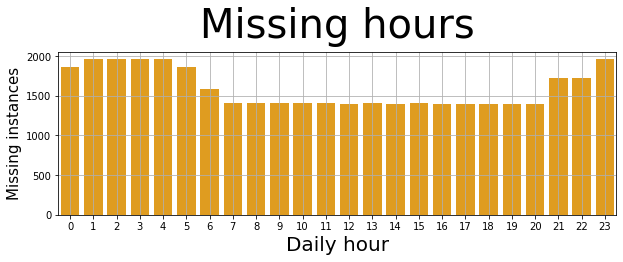

--> Filled the (inverter) missing values.
--> Observations with missing values (239105) have been dropped.

--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- INV2 --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 

ALARMS DF: 46947
INVERTER DF: 13912
--> Columns (7): Cc 1 (A), Vcc 1 (V), Irradiance (W/mq), Amb. Temp (°C), Humidity (%), Atmospheric Pressure (hPa), Rainfall (mm)
--> Missing inverter data: 33530 (71.42 %)


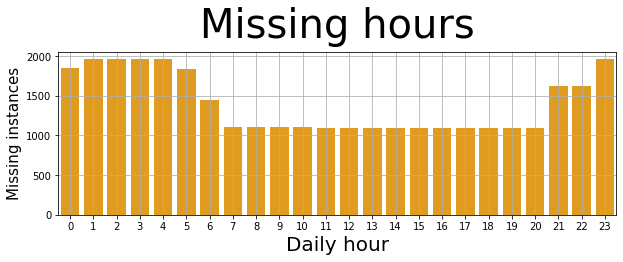

--> Filled the (inverter) missing values.
--> Observations with missing values (178608) have been dropped.

--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- INV3 --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 

ALARMS DF: 46947
INVERTER DF: 14753
--> Columns (7): Cc 1 (A), Vcc 1 (V), Irradiance (W/mq), Amb. Temp (°C), Humidity (%), Atmospheric Pressure (hPa), Rainfall (mm)
--> Missing inverter data: 32694 (69.64 %)


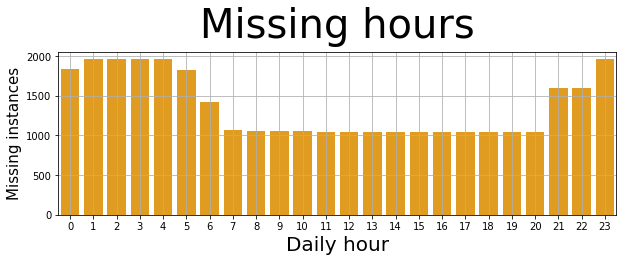

--> Filled the (inverter) missing values.
--> Observations with missing values (176090) have been dropped.

--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- INV4 --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 

ALARMS DF: 46947
INVERTER DF: 9337
--> Columns (7): Cc 1 (A), Vcc 1 (V), Irradiance (W/mq), Amb. Temp (°C), Humidity (%), Atmospheric Pressure (hPa), Rainfall (mm)
--> Missing inverter data: 37624 (80.14 %)


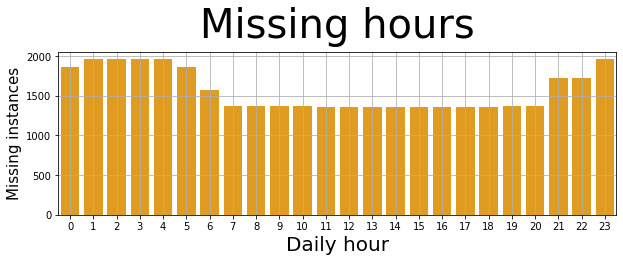

--> Filled the (inverter) missing values.
--> Observations with missing values (227288) have been dropped.


In [33]:
for inv_name in inv_names:
    print("\n" + "-" * 110 + "\n" + "-" * 50, inv_name, "-" * 50 + "\n" + "-" * 110, "\n")
    
    # Retrieve the main dataset
    df = inv_stringBoxes_data[inv_name]
    print("ALARMS DF:", len(df))
    
    # Retrieve the inverter data
    inv_df = inv_data[inv_name]
    inv_df.index = inv_df['Date/Time']
    
    # Select only the relevant columns concerning the inverter
    inv_df = inv_df[selected_inv_columns]
    print("INVERTER DF:", len(inv_df))
    print(f"--> Columns ({len(selected_inv_columns)}):", ', '.join(selected_inv_columns))
    
    # Merge the data
    merged_df = inv_df.merge(df, how = 'right', left_index = True, right_index = True)
 
    # Chech the NaN values
    empty_ts = set(merged_df[merged_df.isnull().values].index)
    empty_hours = np.array(sorted(Counter(item.strftime('%H') for item in empty_ts).most_common(), key = lambda item: item[0]))
    print(f"--> Missing inverter data: {len(empty_ts)} ({(round((len(empty_ts)/len(merged_df))* 100, 2))} %)")

    plt.figure(figsize = (10, 3))
    sns.barplot(x = [int(hour) for hour in empty_hours[:, 0]], y =  [int(counter) for counter in empty_hours[:, 1]], 
                color = 'orange')
    plt.title("Missing hours", fontsize = 40, y = 1.05)
    plt.xlabel('Daily hour', fontsize = 20)
    plt.ylabel('Missing instances', fontsize = 15)
    plt.grid()
    plt.show()
    
    # CASE 1: Fille nan values
    if fill_nan_values:
        merged_df.loc[:, 'Cc 1 (A)'].fillna(method = 'ffill', inplace = True) 
        merged_df.loc[:, 'Vcc 1 (V)'].fillna(method = 'ffill',  inplace = True)
        merged_df.loc[:, 'Irradiance (W/mq)'].fillna(method = 'ffill', inplace = True)
        merged_df.loc[:, 'Amb. Temp (°C)'].fillna(method = 'ffill', inplace = True)
        print("--> Filled the (inverter) missing values.")
    
    # Drop observations that was not filled 
    print(f"--> Observations with missing values ({len(merged_df[merged_df.isnull().values])}) have been dropped.")
    merged_df.dropna(inplace = True)

    # Assign the merged_df to its inverter
    inv_stringBoxes_data[inv_name] = merged_df
    
    #display(merged_df)

## 3.5) Create features for each pair of class and stringbox

In [34]:
class_prefix = 'CLASS'

In [35]:
for inv_name in inv_names:
    print("-" * 110 + "\n" + "-" * 50, inv_name, "-" * 50 + "\n" + "-" * 110, "\n")
    
    # Retrieve the dataset
    df = inv_stringBoxes_data[inv_name]
    #display(df)
    
    # The different cases
    class_col = 'Labels'
    stringBox_cols = [col for col in df.columns 
                      if (col not in selected_inv_columns) and (col != class_col)]
    freq_cols = [col for col in df.columns if 'faulty_strings' in col] 
    
    # Split the data
    partial_dfs = []
    
    # A) Split the labels (i.e., outputs)
    partial_dfs.append(pd.DataFrame(
            data = df[class_col].tolist(), 
            columns = [f'{class_prefix} {ascii_uppercase[idk]}: {class_name}' 
                       for idk, class_name in enumerate(output_classes)], 
            index = df.index
        ))
    
    # Inverter features
    partial_dfs.append(df[selected_inv_columns])
    
    # B) Split the string box data
    for col in stringBox_cols:
        if 'faulty_strings' in col:
            df_data = df[col].apply(lambda arr: arr[:, 0]).tolist()
        else:
            df_data = df[col].tolist()
            
        partial_dfs.append(pd.DataFrame(
            data = df_data, 
            columns = [f'{col}: {class_name}' for class_name in input_classes], 
            index = df.index
        ))
        
    # C) Attach the columns relate to the frequencies
    #partial_dfs.append(df[freq_cols])
        
    # C) Build the merged dataframe
    merged_splitted_df = pd.concat(partial_dfs, axis = 1)
    
    # Save the splitted df
    inv_stringBoxes_data[inv_name] = merged_splitted_df
    print("\t\t\t\t\t\t OK\n")
    #display(merged_splitted_df)

#print("COLUMNS:\n--> " + '\n--> '.join(inv_stringBoxes_data[inv_name].columns))

--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- INV1 --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 

						 OK

--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- INV2 --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 

						 OK

--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- INV3 --------------------------------------------------
--------------------------------------------------------------------------------------------------

## 3.6) Remove reduntant features (i.e., unnecessary pairs)

In [36]:
remove_redundant_features = True

In [37]:
redundant_pairs = {
    'Corrente di stringa fuori range': r"^QC\d$", # QCX
    'String-box con produzione anomala': r"QC\d_.*" # QCX_sY
}

In [38]:
if remove_redundant_features:
    for inv_name in inv_names:
        print("-" * 110 + "\n" + "-" * 50, inv_name, "-" * 50 + "\n" + "-" * 110, "\n")

        # Retrieve the dataset
        df = inv_stringBoxes_data[inv_name]
        
        #display(df.iloc[0])
        cols_to_remove = df.columns.tolist()
        print("TOTAL COLUMNS:", len(cols_to_remove))
        
        # Retrive columns having all zeros (no failure events)
        #summed_df = df.sum(axis = 0)
        #zeros_cols = summed_df[summed_df == 0].index.tolist()

        # Remove the output columns from the columns having all zero values
        [cols_to_remove.remove(col_name) for col_name in cols_to_remove.copy() if class_prefix in col_name]
        
        # Remove the inverter data
        [cols_to_remove.remove(col_name) for col_name in cols_to_remove.copy() if col_name in selected_inv_columns]
        
        # Remove the columns related to the frequency
        #[cols_to_remove.remove(col_name) for col_name in cols_to_remove.copy() if 'faulty_strings' in col_name]
        
        # Select only the unnecessary features (i.e., pairs_to_remove)
        for full_col_name in cols_to_remove.copy():
            component_prefix, alarm = [item.strip() for item in full_col_name.split(':')]

            if alarm in redundant_pairs.keys():
                regex_prefix_to_check = redundant_pairs[alarm]
  
                # Select only features matching the prefix to discard 
                if not match(regex_prefix_to_check, component_prefix):
                    cols_to_remove.remove(full_col_name)
            else:
                # Select only features that is considered as pairs (i.e., pairs_to_remove)
                cols_to_remove.remove(full_col_name)

        # Remove the columns 
        if len(cols_to_remove) > 0:
            print(f"--> Removed {len(cols_to_remove)} columns that were unnecessary!\n"\
                  f"CURRENT FEATURES: from {len(df.columns)} to {len(df.columns) - len(cols_to_remove)}\n")
            print(cols_to_remove)
            df.drop(columns = cols_to_remove, inplace = True)
        else:
            print("There are no unnecessary columns!\n")

--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- INV1 --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 

TOTAL COLUMNS: 29
--> Removed 6 columns that were unnecessary!
CURRENT FEATURES: from 29 to 23

['QC1: Corrente di stringa fuori range', 'QC2: Corrente di stringa fuori range', 'QC3: Corrente di stringa fuori range', 'QC4: Corrente di stringa fuori range', 'QC5: Corrente di stringa fuori range', 'QC6: Corrente di stringa fuori range']
--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- INV2 --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 

T

## Fill the empty timestamps

In [39]:
fill_empty_ts = True

In [40]:
if fill_empty_ts:
    for inv_name in inv_names:  
        print("-" * 40, inv_name, "-" * 40)
        
        inv_stringBoxes_data[inv_name] = lstm_utils.fill_empty_ts(inv_stringBoxes_data[inv_name])
        inv_stringBoxes_data[inv_name].info()

---------------------------------------- INV1 ----------------------------------------
Missing timestamps 5143 out of 8808
The dataframe has been filled with 5143 (58.39 %) missing timestamps.

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13951 entries, 2019-11-27 16:00:00 to 2021-06-30 22:00:00
Data columns (total 23 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   CLASS A: Allarme fusibile su polo negativo           13951 non-null  int64  
 1   CLASS B: Allarme fusibile su polo positivo           13951 non-null  int64  
 2   CLASS C: Isolamento                                  13951 non-null  int64  
 3   CLASS D: String-box con corrente a 0                 13951 non-null  int64  
 4   Cc 1 (A)                                             13951 non-null  float64
 5   Vcc 1 (V)                                            13951 non-null  float64
 6   I

## Merge all the inverter data 

In [41]:
merge_inverter_data = False

In [42]:
verbose = False
dict_name = 'All inverters'

if merge_inverter_data:
    num_inv_within_data = len(inv_names)
    
    # Merge the data
    merged_df = pd.concat([inv_stringBoxes_data[inv_name] for inv_name in inv_names]).sort_index()
    print(f"Inverter data (i.e., {', '.join(inv_names)}) has been merged. "\
          f"The dataset has now {len(merged_df)} observations.")
        
    if verbose:
        print("-" * 58, "EXAMPLE", "-" * 58)
        display(merged_df.loc[merged_df.index[0], :])
    
    # Save the data
    inv_stringBoxes_data[dict_name] = merged_df
    inv_names = [dict_name]  
else:
    num_inv_within_data = 1
    
    # APPROACH 1: Different years (100)
    # APPORACH 2: MultiIndex (inv, ts) --> attenzione per la generazione delle finestre temporali
    
    # Soleto 1--> Test
    # Grid search --> Galatina

## 3.7) Generate the train/test split

In [43]:
train_timestamps = dict()
test_timestamps = dict()

In [44]:
test_size = 0.3

In [45]:
for inv_name in inv_names:
    print("\n" + "-" * 110 + "\n" + "-" * 50, inv_name, "-" * 50 + "\n" + "-" * 110, "\n")
    
    # Get the data
    df = inv_stringBoxes_data[inv_name]
    all_timestamps = df.index.tolist()
    
    output_cols = [col for col in df.columns if class_prefix in col]
    
    # Split the timestamps into train/test
    train_ts, test_ts = train_test_split(all_timestamps, test_size = test_size, shuffle = True, random_state = 101)
    train_timestamps[inv_name] = sorted(train_ts)
    test_timestamps[inv_name] = sorted(test_ts)
    
    print(f"TRAIN SET ({int((1- test_size)*100)} %): {len(train_ts)} obs. \n" + "-" * 50)
    display(df.loc[train_ts, output_cols].sum())
        
    print(f"TEST SET ({int(test_size * 100)} %):  {len(test_ts)} obs. \n" + "-" * 50)
    display(df.loc[test_ts, output_cols].sum())


--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- INV1 --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 

TRAIN SET (70 %): 9765 obs. 
--------------------------------------------------


CLASS A: Allarme fusibile su polo negativo       0
CLASS B: Allarme fusibile su polo positivo       0
CLASS C: Isolamento                              1
CLASS D: String-box con corrente a 0          3874
dtype: int64

TEST SET (30 %):  4186 obs. 
--------------------------------------------------


CLASS A: Allarme fusibile su polo negativo       0
CLASS B: Allarme fusibile su polo positivo       0
CLASS C: Isolamento                              0
CLASS D: String-box con corrente a 0          1639
dtype: int64


--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- INV2 --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 

TRAIN SET (70 %): 17763 obs. 
--------------------------------------------------


CLASS A: Allarme fusibile su polo negativo       0
CLASS B: Allarme fusibile su polo positivo       0
CLASS C: Isolamento                              1
CLASS D: String-box con corrente a 0          5843
dtype: int64

TEST SET (30 %):  7613 obs. 
--------------------------------------------------


CLASS A: Allarme fusibile su polo negativo       0
CLASS B: Allarme fusibile su polo positivo       0
CLASS C: Isolamento                              1
CLASS D: String-box con corrente a 0          2467
dtype: int64


--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- INV3 --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 

TRAIN SET (70 %): 17763 obs. 
--------------------------------------------------


CLASS A: Allarme fusibile su polo negativo       0
CLASS B: Allarme fusibile su polo positivo      83
CLASS C: Isolamento                             41
CLASS D: String-box con corrente a 0          7957
dtype: int64

TEST SET (30 %):  7613 obs. 
--------------------------------------------------


CLASS A: Allarme fusibile su polo negativo       0
CLASS B: Allarme fusibile su polo positivo      33
CLASS C: Isolamento                             31
CLASS D: String-box con corrente a 0          3406
dtype: int64


--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- INV4 --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 

TRAIN SET (70 %): 11391 obs. 
--------------------------------------------------


CLASS A: Allarme fusibile su polo negativo       0
CLASS B: Allarme fusibile su polo positivo       0
CLASS C: Isolamento                              0
CLASS D: String-box con corrente a 0          4699
dtype: int64

TEST SET (30 %):  4882 obs. 
--------------------------------------------------


CLASS A: Allarme fusibile su polo negativo       0
CLASS B: Allarme fusibile su polo positivo       0
CLASS C: Isolamento                              0
CLASS D: String-box con corrente a 0          2048
dtype: int64

## 3.8) Standard scaler

In [46]:
standardize_input_data = True

In [47]:
data_std_scalers = dict()
if standardize_input_data:
    for inv_name in inv_names:
        print("\n" + "-" * 110 + "\n" + "-" * 50, inv_name, "-" * 50 + "\n" + "-" * 110)
        
        # Retrieve the data
        df = inv_stringBoxes_data[inv_name]
        train_ts = train_timestamps[inv_name]
        
        # Select only the columns concerning the input features
        cols_to_strandardized = [col_name for col_name in df.columns 
                                 if (class_prefix not in col_name) and ('faulty_strings'not in col_name)]
                
        skipped_cols = sorted(set(df.columns) - set(cols_to_strandardized))
        print(f"Skipped the following ({len(skipped_cols)}) columns:\n--> " + '\n--> '.join(skipped_cols))
        
        # Fit and save the standardScaler
        scaler = StandardScaler().fit(df.loc[train_ts, cols_to_strandardized])
        data_std_scalers[inv_name] = scaler
        
        df.loc[:, cols_to_strandardized] = pd.DataFrame(data = scaler.transform(df[cols_to_strandardized]),
                                                        index = df.index, 
                                                        columns = cols_to_strandardized)
        print("\n\t\t\t\t OK: Data has been standardized.\n")
else:
    print("This pre-processing step (Data standardization) has not been selected.")
    
# fit --> su tutti gli inverter (train set)
# tranform --> per ogni inverter (train/test set)


--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- INV1 --------------------------------------------------
--------------------------------------------------------------------------------------------------------------
Skipped the following (10) columns:
--> CLASS A: Allarme fusibile su polo negativo
--> CLASS B: Allarme fusibile su polo positivo
--> CLASS C: Isolamento
--> CLASS D: String-box con corrente a 0
--> QC1_faulty_strings: Corrente di stringa fuori range
--> QC2_faulty_strings: Corrente di stringa fuori range
--> QC3_faulty_strings: Corrente di stringa fuori range
--> QC4_faulty_strings: Corrente di stringa fuori range
--> QC5_faulty_strings: Corrente di stringa fuori range
--> QC6_faulty_strings: Corrente di stringa fuori range

				 OK: Data has been standardized.


---------------------------------------------------------------------------------------------------

In [48]:
for inv_name in inv_names:
    print("\n" + "-" * 110 + "\n" + "-" * 50, system_name, ":", inv_name, "-" * 50 + "\n" + "-" * 110)
        
    scaler = data_std_scalers[inv_name]
    
    file_path = path.join(main_folder_path, 'Params', f'{inv_name}_stdScaler_generalizedApproch.txt')
    
    with open(file_path, 'w') as txt_file:
        txt_file.write(f"\n[Standard Scaler] [{inv_name}]\n")
        txt_file.write("FEATURES:\n" + ','.join(scaler.feature_names_in_)+ "\n")
        txt_file.write("MEAN:\n" + ','.join([str(value) for value in scaler.mean_]) + "\n")
        txt_file.write("VARIANCE:\n" + ','.join([str(value) for value in scaler.var_]) + "\n")
        
        print(f"[{inv_name}] The paramaters (i.e., mean and variance) of the standard scaler have been saved. ")  


--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- Galatina : INV1 --------------------------------------------------
--------------------------------------------------------------------------------------------------------------
[INV1] The paramaters (i.e., mean and variance) of the standard scaler have been saved. 

--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- Galatina : INV2 --------------------------------------------------
--------------------------------------------------------------------------------------------------------------
[INV2] The paramaters (i.e., mean and variance) of the standard scaler have been saved. 

--------------------------------------------------------------------------------------------------------------
----------------------------

## Data exploration
### Feature selection

In [49]:
visualize_exploration = False

In [50]:
if visualize_exploration:
    for inv_name in inv_names:
        
        # Retrieve the data
        df = inv_stringBoxes_data[inv_name]

        output_cols = [col for col in df.columns if class_prefix in col]
        inputs_cols = np.array([col for col in df.columns if col not in output_cols])

        # Input data
        inputs = df[inputs_cols]
        outputs = df[output_cols]

        # Tree
        clf = ExtraTreesClassifier(n_estimators = 500, random_state = 101)
        clf.fit(inputs, outputs)

        # Get the coef.
        importance = list(zip(inputs_cols, clf.feature_importances_))
        importance = sorted(importance, key = lambda item: item[1], reverse = True)

        # Visulize
        fig, axes = plt.subplots(figsize = (10, 20),  facecolor = "white")
        fig.suptitle(f"{system_name.upper()}: Inverter n°{inv_name[-1]}", fontsize = 60, color = 'firebrick')
        sns.barplot(x = [item[1] for item in importance], 
                    y = [item[0] for item in importance], 
                    palette = ['red' if feature_name in selected_inv_columns else 'orange' for feature_name, _ in importance],
                    ax = axes)
        axes.set_title("Feature importances via coefficients", pad = 20, size = 30)
        axes.tick_params(axis = 'x', top = True, labeltop = True)
        plt.show()

## 3.9) [END] Data preparation

In [51]:
idk = 0
print("-" * 110 + "\n" + "-" * 50, "DATA:", inv_names[idk], "-" * 50 + "\n" + "-" * 110, "\n")
inv_stringBoxes_data[inv_names[idk]].info()
display(inv_stringBoxes_data[inv_names[idk]])

--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- DATA: INV1 --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13951 entries, 2019-11-27 16:00:00 to 2021-06-30 22:00:00
Data columns (total 23 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   CLASS A: Allarme fusibile su polo negativo           13951 non-null  int64  
 1   CLASS B: Allarme fusibile su polo positivo           13951 non-null  int64  
 2   CLASS C: Isolamento                                  13951 non-null  int64  
 3   CLASS D: String-box con corrente a 0                 13951 non-null  int64  
 4   Cc 1 (A)              

,CLASS A: Allarme fusibile su polo negativo,CLASS B: Allarme fusibile su polo positivo,CLASS C: Isolamento,CLASS D: String-box con corrente a 0,Cc 1 (A),Vcc 1 (V),Irradiance (W/mq),Amb. Temp (°C),Humidity (%),Atmospheric Pressure (hPa),...,QC3_strings_time: Corrente di stringa fuori range,QC4_strings_time: Corrente di stringa fuori range,QC5_strings_time: Corrente di stringa fuori range,QC6_strings_time: Corrente di stringa fuori range,QC1_faulty_strings: Corrente di stringa fuori range,QC2_faulty_strings: Corrente di stringa fuori range,QC3_faulty_strings: Corrente di stringa fuori range,QC4_faulty_strings: Corrente di stringa fuori range,QC5_faulty_strings: Corrente di stringa fuori range,QC6_faulty_strings: Corrente di stringa fuori range
2019-11-27 16:00:00,0,0,0,0,-0.278171,0.829205,0.640421,0.665033,0.694681,0.758298,...,-0.121029,-0.374062,-0.437216,-0.369733,0.0,0.0,0.0,0.0,0.0,0.0
2019-11-27 17:00:00,0,0,0,0,-0.637450,0.291668,-0.467219,0.502662,1.040618,0.758113,...,-0.121029,-0.374062,-0.437216,-0.369733,0.0,0.0,0.0,0.0,0.0,0.0
2019-11-27 18:00:00,0,0,0,0,-0.637450,-0.922767,-0.628894,0.346676,1.283504,0.758790,...,-0.121029,-0.374062,-0.437216,-0.369733,0.0,0.0,0.0,0.0,0.0,0.0
2019-11-27 19:00:00,0,0,0,0,-0.637450,-0.947653,-0.628894,0.273700,1.400860,0.759016,...,-0.121029,-0.374062,-0.437216,-0.369733,0.0,0.0,0.0,0.0,0.0,0.0
2019-11-27 20:00:00,0,0,0,0,-0.637450,-0.947653,-0.628894,0.272788,1.458370,0.758770,...,-0.121029,-0.374062,-0.437216,-0.369733,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-30 18:00:00,0,0,0,0,0.067289,0.928749,0.065961,2.117254,-0.194537,0.756697,...,-0.121029,-0.374062,-0.437216,-0.369733,0.0,0.0,0.0,0.0,0.0,0.0
2021-06-30 19:00:00,0,0,0,0,-0.250534,0.963589,-0.222988,1.923868,0.153443,0.757498,...,-0.121029,-0.374062,-0.437216,-0.369733,0.0,0.0,0.0,0.0,0.0,0.0
2021-06-30 20:00:00,0,0,0,0,-0.582177,0.973544,-0.515378,1.579057,1.000332,0.757662,...,-0.121029,-0.374062,-0.437216,-0.369733,0.0,0.0,0.0,0.0,0.0,0.0
2021-06-30 21:00:00,0,0,0,0,-0.637450,0.097558,-0.639213,1.448612,1.134036,0.757518,...,-0.121029,-0.374062,-0.437216,-0.369733,0.0,0.0,0.0,0.0,0.0,0.0


# Logistic LSTM 

In [52]:
grid_search = True

In [53]:
pre_trained = False

## Fixed parameters

In [54]:
num_epochs = 100
batch_size = 16 * num_inv_within_data

In [55]:
enconding_one_obs = True

## Create the saving folders

In [56]:
trained_inv_model = dict()

In [57]:
main_saving_folder = 'UC2 - LSTM'
saving_path = path.join(system_path, "..", "..", main_saving_folder)

if not path.exists(main_saving_folder):
    makedirs(main_saving_folder)
    print(f"The folder '{saving_folder}' has been created!")

In [58]:
version = " - Generalized Version"
subfolders = ['Grid search' + version, 'Trained models' + version, 'Test metrics' + version]
for subfolder in subfolders:
    sub_saving_path = path.join(saving_path, subfolder)
    
    if not path.exists(sub_saving_path):
        makedirs(sub_saving_path)
        print(f"The sub-folder '{main_saving_folder}/{subfolder}' has been created!")

## Grid search

### The parameters

In [59]:
neurons_values = [32, 64, 92, 128, 192, 256]
window_dims = [1, 12, 24, 36, 48, 72, 96, 120, 168, 216, 264]

### The function

In [60]:
verbose = True

In [ ]:
grid_search_best_params = dict()
if grid_search and not pre_trained: 
    
    inv_best_scores = dict()
    
    for inv_name in inv_names:
        print("-" * 110 + "\n" + "-" * 50, inv_name, "-" * 50 + "\n" + "-" * 110, "\n")

        # Retrieve the dataset
        df = inv_stringBoxes_data[inv_name]
        train_ts = train_timestamps[inv_name]
        
        # Skip the first x hours to use the same data for each combination
        first_ts = df.index[0] + pd.Timedelta(window_dims[-1], unit = 'hours')
        df = df[first_ts:]

        # Build the train/validation splits
        output_cols = [col for col in df.columns if class_prefix in col]

        best_scores = None

        # Test the combiantion of the two hyper-parameters
        print("-" * 110 + "\n" + "-" * 50, "GRID SEARCH", "-" * 50 + "\n" + "-" * 110)
        for j, dim_window in enumerate(window_dims):
            
            # Generate the data for the temporal window
            # X: [obs., hours, features] ---- Y: [obs., classes]
            x_values, y_values, x_feature_names, timestamps = lstm_utils.generate_data_sequences(df, output_cols, dim_window, 
                                                                                                 enconding_one_obs, 
                                                                                                 num_inv_within_data, verbose)
            
            # Isolate only the rows concerning training observations
            train_idks = np.argwhere(np.isin(timestamps, train_ts)).flatten()
            train_x_values = x_values[train_idks]
            train_y_values = y_values[train_idks]
            
            # Perform the train/validation split
            valid_dim = 0.2
            x_train, x_valid, y_train, y_valid = train_test_split(train_x_values, train_y_values, test_size = valid_dim, 
                                                                  shuffle = True, random_state = 101)
            num_input_features = x_train.shape[-1]
            num_output_classes = y_train.shape[-1]
            
            for i, starting_num_neurons in enumerate(neurons_values):
                print("\n" + "-" * 40)
                print(f"({i + 1}/{len(neurons_values)}) Starting neurons:", starting_num_neurons)
                print(f"({j + 1}/{len(window_dims)}) Temporal window:", dim_window, "hours")
                print("-" * 40, "\n")
                print("INPUT DATA:", x_values.shape)
                print("--> [TRAIN] INPUT DATA:", x_train.shape)
                print("--> [VALID] INPUT DATA: ", x_valid.shape)
                print("\nOUTPUT DATA:", y_values.shape)
                print("--> [TRAIN] OUTPUT DATA:", y_train.shape)
                print("--> [VALID] OUTPUT DATA: ", y_valid.shape, "\n")
                
                # Initialize the LSTM network
                lstm_model = lstm_utils.initialize_lstm(starting_num_neurons, dim_window, num_inv_within_data, 
                                                        num_input_features, num_output_classes, enconding_one_obs)

                # Train the LSTM 
                history, best_config_perfomances = lstm_utils.train_model(lstm_model, (x_train, y_train), (x_valid, y_valid), 
                                                                          num_epochs, batch_size, shuffle_flag = True, 
                                                                          visualize_graph = True)
                
                best_config_perfomances['Starting neurons'] = starting_num_neurons
                best_config_perfomances['Window dimensions'] = dim_window

                 # Save the perfomance of this configuration in a log file
                log_file_name = f'lstm_gridSearch_perfomance_{inv_name}' + ".txt"
                with open(path.join(saving_path, subfolders[0], log_file_name), 'a') as log_file:
                    for key, value in best_config_perfomances.items():
                        if isinstance(value, float) or isinstance(value, np.int64):
                            value = np.round(value, 4)
                        log_file.write(f'{key.upper()}: {value}\n')
                    log_file.write("-" * 50 + "\n")

                # Monitor perfomance (i.e., compare the perfomance with the best one recorded)
                metrics_to_monitor = 'Val ' + 'f1 score'  # "loss", "binary accuracy", "precision"
                if (not best_scores) or (best_config_perfomances[metrics_to_monitor] > best_scores[metrics_to_monitor]):

                    # Save the perfomance
                    best_scores = best_config_perfomances

                    # Save the trained model 
                    trained_inv_model[inv_name] = lstm_model
                else:
                    print("It's not the best!. Delta from the best: "\
                          f"{best_config_perfomances[metrics_to_monitor] - best_scores[metrics_to_monitor]}")

        # Visualize and save the best perfomance
        print("\n"+ "-" * 110 + "\n" + "-" * 40, "FINDINGS of the GRID SEARCH", "-" * 40 + "\n" + "-" * 110, "\n")
        grid_search_best_params[inv_name] = best_scores
        
        best_perfomance_name = f'best_perfomance_{inv_name}' + ".txt"
        with open(path.join(saving_path, subfolders[0], best_perfomance_name), 'w') as log_file:
            for key, value in best_scores.items():
                if isinstance(value, float) or isinstance(value, np.int64):
                    value = np.round(value, 4)
                log_file.write(f'{key.upper()}: {value}\n')
                print(f'{key}: {value}')
                
        inv_best_scores[inv_name] = best_scores
else:
    print("This step has been skipped.")

--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- INV1 --------------------------------------------------
-------------------------------------------------------------------------------------------------------------- 

--------------------------------------------------------------------------------------------------------------
-------------------------------------------------- GRID SEARCH --------------------------------------------------
--------------------------------------------------------------------------------------------------------------

----------------------------------------
(1/6) Starting neurons: 32
(1/11) Temporal window: 1 hours
---------------------------------------- 

INPUT DATA: (13687, 1, 19)
--> [TRAIN] INPUT DATA: (7668, 1, 19)
--> [VALID] INPUT DATA:  (1918, 1, 19)

OUTPUT DATA: (13687, 4)
--> [TRAIN] OUTPUT DATA: (7668, 4)
--> [VALID] OUTPUT DATA: 

## Train the LSTM

### Hyperparameters

In [ ]:
avg_config = False

In [ ]:
params = {
    'INV1': {
        'num_neurons': 92, 
        'window_length': 12
    },
    'INV2': {
        'num_neurons': 32, 
        'window_length': 216
    },
    'INV3': {
        'num_neurons':64, 
        'window_length':6
    },
    'INV4': {
        'num_neurons':192, 
        'window_length':264
    }
}
                    
if avg_config:
    params = {inv_name : {'num_neurons': 64, 'window_length' : 72} for inv_name in params.keys()}
    
if merge_inverter_data: 
    params = {dict_name: {'num_neurons': 192, 'window_length': 2}}

if not pre_trained:
    display(params)

### Carry out the train stage for each inverter 

In [ ]:
if not grid_search and not pre_trained:
    for inv_name in inv_names:
        print("-" * 110 + "\n" + "-" * 50, inv_name, "-" * 50 + "\n" + "-" * 110, "\n")

        # Retrieve the inverter dataset
        df = inv_stringBoxes_data[inv_name]
        train_ts = train_timestamps[inv_name]
        print("ALL DATA:", len(df))
        
        # Build the train/validation splits
        output_cols = [col for col in df.columns if class_prefix in col]

        # Retrieve the inverter parameters
        num_neurons = params[inv_name]['num_neurons']
        window_length = params[inv_name]['window_length']
        
        # Generate the data for the temporal window
        print(f"--> Generating the data sequences (temporal window: {window_length} hours)\n")
        x_values, y_values, x_feature_names, timestamps = lstm_utils.generate_data_sequences(df, output_cols, window_length, 
                                                                                             enconding_one_obs, 
                                                                                             num_inv_within_data, verbose)
        print("X VALUES:", x_values.shape)
        print("Y VALUES:", y_values.shape)
        
        # Isolate only the rows concerning training observations
        train_idks = np.argwhere(np.isin(timestamps, train_ts)).flatten()
        train_x_values = x_values[train_idks]
        train_y_values = y_values[train_idks]

        # Perform the train/validation split
        valid_dim = 0.2
        x_train, x_valid, y_train, y_valid = train_test_split(train_x_values, train_y_values, test_size = valid_dim, 
                                                              shuffle = True, random_state = 101)
        print("-" * 40)
        print("INPUT DATA:", x_values.shape)
        print("--> [TRAIN] INPUT DATA:", x_train.shape)
        print("--> [VALID] INPUT DATA: ", x_valid.shape)
        print("\nOUTPUT DATA:", y_values.shape)
        print("--> [TRAIN] OUTPUT DATA:", y_train.shape)
        print("--> [VALID] OUTPUT DATA: ", y_valid.shape)
        print("-" * 40, "\n")
    
        num_input_features = x_train.shape[-1]
        num_output_classes = y_train.shape[-1]

        # Initialize the LSTM
        lstm_model = lstm_utils.initialize_lstm(num_neurons, window_length, num_inv_within_data, num_input_features, 
                                                num_output_classes, enconding_one_obs)

        # Train the LSTM 
        graph_file_path = path.join(saving_path, subfolders[1], 
                                    f'{inv_name}_{num_neurons}N{window_length}h_modelPerfomance.png')
        history, best_perfomances = lstm_utils.train_model(lstm_model, (x_train, y_train), (x_valid, y_valid), num_epochs, 
                                                           batch_size, shuffle_flag = True, visualize_graph = True, 
                                                           saving_graph_path = graph_file_path)

        # Save the trained LSTM
        trained_inv_model[inv_name] = lstm_model
else:
    print("This step has been skipped.")



## Save the trained models

In [ ]:
if not pre_trained:
    for inv_name in inv_names:
        print("-" * 110 + "\n" + "-" * 50, inv_name, "-" * 50 + "\n" + "-" * 110, "\n")
        
        trained_lstm = trained_inv_model[inv_name]

        # Save the best model
        file_name = f'{inv_name}_trained_model'
        
        if grid_search: 
            file_name += '_' + str(grid_search_best_params[inv_name]['Starting neurons']) + 'N' 
            file_name += '_' + str(grid_search_best_params[inv_name]['Window dimensions']) + "H"
        else: 
            file_name += '_' + str(params[inv_name]['num_neurons']) + 'N_' + str(params[inv_name]['window_length']) + "H"
            
        file_path = path.join(saving_path, subfolders[1], file_name)
        trained_lstm.save(file_path)
else:
    print("This step has been skipped.")

## Load the trained models

In [ ]:
if pre_trained:
    if system_name == SYSTEM_NAMES[2]:
        if avg_config:
            config_to_load = {inv_name : {'num_neurons': 64, 'window_length' : 72} for inv_name in inv_names}
        else:
            config_to_load = {
                'INV1': {
                    'num_neurons': 92, 
                    'window_length': 12
                },
                'INV2': {
                    'num_neurons': 32, 
                    'window_length':216
                },
                'INV4': {
                    'num_neurons': 192, 
                    'window_length': 264
                }
            }  
    elif system_name == SYSTEM_NAMES[3]:
        if avg_config:
            config_to_load = {inv_name : {'num_neurons': 256, 'window_length' : 120} for inv_name in inv_names}
        else:
            config_to_load = {
                'INV1': {
                    'num_neurons': 32, 
                    'window_length': 168, 
                },
                'INV2': {
                    'num_neurons': 256, 
                    'window_length':120,
                }
            }
    elif system_name == SYSTEM_NAMES[4]:
        if avg_config:
            config_to_load = {inv_name : {'num_neurons': 192, 'window_length' : 12} for inv_name in inv_names}
        else:
            config_to_load = {
                'INV1': {
                    'num_neurons': 0, 
                    'window_length':0,
                },
                'INV2': {
                    'num_neurons': 0, 
                    'window_length':0,
                },
                'INV3': {
                    'num_neurons':0, 
                    'window_length':0,
                },
                'INV4': {
                    'num_neurons':0, 
                    'window_length':0,
                }
        }
    print("-" * 12, f"PV System: {system_name}", "-" * 12)
    print("--> "+ '\n--> '.join([f"{inv_name}: {config['num_neurons']} starting neurons with {config['window_length']} hours" 
                                 for inv_name, config in config_to_load.items()]))

In [ ]:
if pre_trained:
    for inv_name in inv_names:
        print("-" * 110 + "\n" + "-" * 50, inv_name, "-" * 50 + "\n" + "-" * 110, "\n")

        # Load the model
        file_name = f'{inv_name}_trained_model'
        file_name += "_" + str(config_to_load[inv_name]["num_neurons"]) + "N"
        file_name += "_" + str(config_to_load[inv_name]["window_length"]) + "H"
        file_path = path.join(saving_path, subfolders[1], file_name)
        loaded_inv_model = load_model(file_path)
        loaded_inv_model.summary()
        
        # Save the loaded model for each inverter
        trained_inv_model[inv_name] = loaded_inv_model
        
        print("\t\t\t\tThe trained LSTM model has been loaded.\n")

## Predict the classes (i.e., allarms)

In [ ]:
prob_threshold = 0.5

In [ ]:
verbose = True

In [ ]:
inv_metrics = dict()
for inv_name in inv_names:
    print("-" * 110 + "\n" + "-" * 50, inv_name, "-" * 50 + "\n" + "-" * 110, "\n")
    
    # Retrieve the dataset
    df = inv_stringBoxes_data[inv_name]
    
    # Retrieve the test timestamps 
    test_ts = test_timestamps[inv_name] 
    #test_ts = pd.date_range(start = '2021-06-09 11:00', end ='2021-06-30 22:00', periods=None, freq='1H')
    #print(f"Period selected: FROM '{df.index[0].strftime('%Y-%m-%d (%H:%M)')}' TO '{df.index[-1].strftime('%Y-%m-%d (%H:%M)')}' "\
    #f"|| {df.index[-1] - df.index[0]}")
    
    print(f"TEST SET ({int((len(test_ts) / len(df)) * 100)} %):  {len(test_ts)} obs. \n" + "-" * 50)
    display(df.loc[test_ts, output_cols].sum())
    
    # Retrieve the trained model
    model = trained_inv_model[inv_name]
    
    if grid_search:
        window_length = inv_best_scores[inv_name]['Window dimensions']
    if pre_trained:
        window_length = config_to_load[inv_name]['window_length']
    else:
        window_length = params[inv_name]['window_length']
    
    # Prepare the input data 
    print(f"--> Generating the data sequences (temporal window: {window_length} hours)\n")
    x_values, y_values, x_feature_names, timestamps = lstm_utils.generate_data_sequences(df, output_cols, window_length, 
                                                                                         enconding_one_obs, num_inv_within_data,
                                                                                         verbose)
    #print("INPUT DATA", input_data.shape)
    #display(input_data)
    
    # Isolate only the rows concerning training observations
    test_idks = np.argwhere(np.isin(timestamps, test_ts)).flatten()
    test_x_values = x_values[test_idks]
    test_y_values = y_values[test_idks]
        
    # Get the output of the model
    predictions = model.predict(test_x_values, batch_size, verbose = 0)
    #display(pd.DataFrame(data = predictions, columns = output_cols).describe())
    
    # Turn the probabilities into binary classes
    predicted_classes = np.where(predictions <= prob_threshold, 0, 1)
    
    assert predicted_classes.shape == test_y_values.shape, f'DIMENSIONAL ERROR: TEST DATA: {y_classes.shape} '\
                                                       f'!= PREDICTED DATA: {predicted_classes.shape}'
    # Compute the metrics for each class
    class_metrics = lstm_utils.evaluate_predictions(predicted_classes, test_y_values, output_cols, verbose)
           
    # Save the metrics
    metrics_df = pd.DataFrame.from_dict(class_metrics, orient = 'index')
    metrics_df.iloc[:, :-1] = (metrics_df.iloc[:, :-1] * 100).round(decimals = 2)
    print("\n" + "-" * 40, inv_name + ": METRICS", "-" * 40)
    display(metrics_df)
    
    # Add a row for the avg scores
    avg_df = metrics_df.iloc[:, :-2].mean().to_frame().transpose().round(decimals = 2)
    avg_df['Hourly events'] = metrics_df['Hourly events'].sum()
    avg_df.index = ['[AVG] ALL classes']
    display(avg_df)
    
    # Visualize and save the metrics
    inv_metrics[inv_name] = metrics_df

## Overview

In [ ]:
file_name = 'Metrics' + ('_AVG_configs' if avg_config else '')
file_path = path.join(saving_path, subfolders[2], file_name + '.xlsx')

writer = pd.ExcelWriter(file_path)

In [ ]:
print("-" * 110 + "\n" + "-" * 50, "OVERVIEW: Alarms", "-" * 50 + "\n" + "-" * 110, "\n")
list_metrics = []
for inv_name, metrics in inv_metrics.items():
    if not isinstance(metrics.index, pd.MultiIndex):
        metrics.index = pd.MultiIndex.from_tuples(tuple(zip([inv_name for j in range(len(df))], metrics.index)))
    list_metrics.append(metrics)
alarm_overall_metrics = pd.concat(list_metrics)
display(alarm_overall_metrics)

# Save as excel
alarm_overall_metrics.to_excel(writer, sheet_name = "By inverters")

In [ ]:
# A.2) Grouped metrics
alarm_overall_metrics = alarm_overall_metrics.droplevel(level = 0)
alarm_overall_metrics = alarm_overall_metrics.groupby(by = alarm_overall_metrics.index)
grouped_alarm_overall_metrics = alarm_overall_metrics.mean()
grouped_alarm_overall_metrics['Hourly events'] = alarm_overall_metrics.sum()['Hourly events']
grouped_alarm_overall_metrics = grouped_alarm_overall_metrics.round(decimals = 2)
display(grouped_alarm_overall_metrics)

# Save as excel
grouped_alarm_overall_metrics.to_excel(writer, sheet_name = "By alarms")

if pre_trained:
    model_configs = pd.DataFrame().from_dict(config_to_load, orient = 'index')
else:
    model_configs = pd.DataFrame().from_dict(params, orient = 'index')
model_configs = model_configs.loc[inv_names, :]
model_configs.to_excel(writer, sheet_name = "Configs")

writer.save()

In [ ]:
print("-" * 110 + "\n" + "-" * 50, "OVERVIEW: Inverters", "-" * 50 + "\n" + "-" * 110, "\n")
inv_overall_metrics = pd.DataFrame.from_dict({"[AVG] " + inv_name: metrics.iloc[:, :-1].mean()
                                              for inv_name, metrics in inv_metrics.items()},
                                             orient = 'index').round(decimals = 2)
display(inv_overall_metrics)
display(inv_overall_metrics.mean().to_frame().round(2).transpose().rename(index = {0: '[AVG] INVs'}))